In [7]:
import os
import glob
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [402]:
dir_Count = len(next(os.walk('./Test Image Dataset'))[1])
num_dirs_processed = 0

for dir, subdirs, files in tqdm(os.walk("./Test Image Dataset")):
    file_num = 0 + num_dirs_processed
    for f in files:
        f_new = str(file_num) + ".jpg"
        os.rename(os.path.join(dir, f), os.path.join(dir, f_new))
        file_num += dir_Count
    num_dirs_processed += 1

3it [00:01,  2.31it/s]


In [8]:
maxImageNum = 0

for dir in os.listdir('./Test Image Dataset'):
    for filepath in (os.listdir('./Test Image Dataset/'+ dir)):
        if int(filepath.split(".")[0]) > maxImageNum:
            maxImageNum = int(filepath.split(".")[0])

def check_train_file(path):
    imageNum = int(path.split("\\")[2].split(".")[0])
    if imageNum > int(round(maxImageNum*0.2, 0)):
        return True

def check_val_file(path):
    imageNum = int(path.split("\\")[2].split(".")[0])
    if imageNum <= int(round(maxImageNum*0.2, 0)) and imageNum > int(round(maxImageNum*0.1, 0)):
        return True

def check_test_file(path):
    imageNum = int(path.split("\\")[2].split(".")[0])
    if imageNum <= int(round(maxImageNum*0.1, 0)):
        return True

transform = transforms.Compose(
        [transforms.Resize((150,150)),
         transforms.Grayscale(),
         transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))])

train_data = torchvision.datasets.ImageFolder('./Test Image Dataset', is_valid_file=check_train_file, transform=transform)
val_data = torchvision.datasets.ImageFolder('./Test Image Dataset', is_valid_file=check_val_file, transform=transform)
test_data = torchvision.datasets.ImageFolder('./Test Image Dataset', is_valid_file=check_test_file, transform=transform)

totalLength = len(train_data) + len(val_data) + len(test_data)
num_classes = len(next(os.walk('./Test Image Dataset'))[1])

print("The training set size is", len(train_data), " (~", round(len(train_data)/totalLength*100, 0), "% of total dataset)")
print("The validation set size is", len(val_data), " (~", round(len(val_data)/totalLength*100, 0), "% of total dataset)")
print("The testing set size is", len(test_data), " (~", round(len(test_data)/totalLength*100, 0), "% of total dataset)")

The training set size is 1600  (~ 80.0 % of total dataset)
The validation set size is 200  (~ 10.0 % of total dataset)
The testing set size is 200  (~ 10.0 % of total dataset)


In [13]:
class BaselineModel(nn.Module):
    
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.name="baseline"
        self.layer1 = nn.Linear(150 * 150, 5000)
        self.layer2 = nn.Linear(5000, 30)
        self.layer3 = nn.Linear(30, 1)
        self.dropout1 = nn.Dropout(p=0.5)
        
    def forward(self, img):
        flattened = img.view(-1, 150 * 150)
        activation1 = F.leaky_relu(self.layer1(flattened))
        activation1 = self.dropout1(activation1)
        activation2 = F.leaky_relu(self.layer2(activation1))
        output = self.layer3(activation2)
        output = output.squeeze(1)
        
        return output

In [14]:
def get_accuracy(model, batch_size, train=False):
    if train:
        data = train_data
    else:
        data = val_data

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        
        if train:
            model.train()
            output = model(imgs)
        else:
            model.eval()
            with torch.no_grad():
                output = model(imgs)
                
        pred = torch.round(torch.sigmoid(output))
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
        
    return correct / total

In [15]:
def train(model, data, batch_size=64, num_epochs=10 , learning_rate = 0.01, weight_decay=0.01, print_stat = 1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    start_time = time.time()
    n = 0
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            
            out = model(imgs)             # forward pass
            loss = criterion(out, labels.float()) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            n += 1
            
        train_acc.append(get_accuracy(model, batch_size, train=True)) # compute training accuracy
        val_acc.append(get_accuracy(model, batch_size, train=False))  # compute validation accuracy
        print(("Epoch {}: Train Acc: {} | " + "Validation Acc: {}").format(
                epoch + 1,
                train_acc[-1],
                val_acc[-1]))    

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(range(1 ,num_epochs+1), train_acc, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 1: Train Acc: 0.605 | Validation Acc: 0.525
Epoch 2: Train Acc: 0.651875 | Validation Acc: 0.58
Epoch 3: Train Acc: 0.67625 | Validation Acc: 0.555
Epoch 4: Train Acc: 0.71625 | Validation Acc: 0.65
Epoch 5: Train Acc: 0.72125 | Validation Acc: 0.595
Epoch 6: Train Acc: 0.74625 | Validation Acc: 0.62
Epoch 7: Train Acc: 0.764375 | Validation Acc: 0.63
Epoch 8: Train Acc: 0.78875 | Validation Acc: 0.635
Epoch 9: Train Acc: 0.774375 | Validation Acc: 0.64
Epoch 10: Train Acc: 0.826875 | Validation Acc: 0.65
Finished Training
Total time elapsed: 363.27 seconds


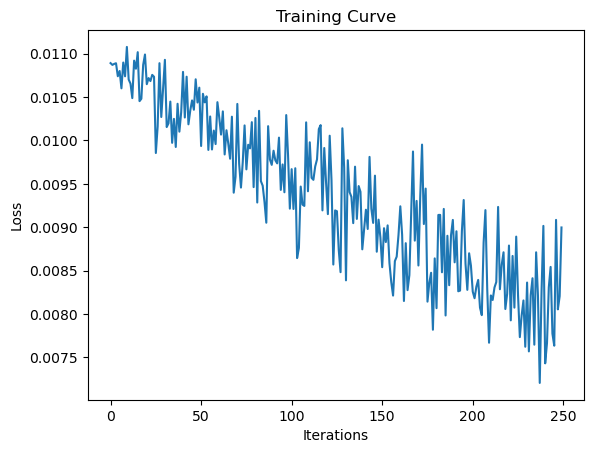

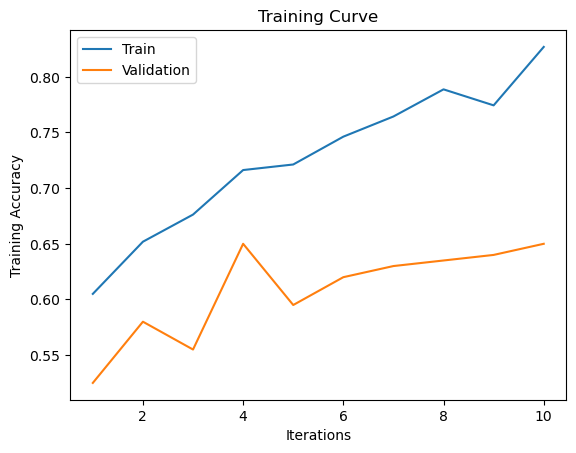

Final Training Accuracy: 0.826875
Final Validation Accuracy: 0.65


In [17]:
model = BaselineModel()
model.cuda()
train(model, train_data, batch_size=64, learning_rate=1e-5, weight_decay=0.01, num_epochs=10)